# 使用OpenCV Haar 聯級法偵測人臉及眼睛位置

使用聯級法偵測速度極快，但正確率不佳，有很多干擾因素，包括人臉尺寸、歪斜、轉動、光影、部份重疊、複雜背景等。  
參考資料來源：https://docs.opencv.org/4.1.2/db/d28/tutorial_cascade_classifier.html  
歐尼克斯實境互動工作室 OmniXRI Jack, 2022.04.25整理製作  

## 1. 檢查Colab已安裝套件（可略過）
本範例主要需用到下列套件，Colab預設已安裝下列版本  
opencv-python                 4.1.2.30  
numpy                         1.21.6  
requests                      2.23.0
matplotlib                    3.2.2  
可利用pip list指令進行檢查


In [1]:
!pip list # 檢查python已安裝套件包（可略過）

Package                       Version
----------------------------- ---------------------
absl-py                       1.0.0
alabaster                     0.7.12
albumentations                0.1.12
altair                        4.2.0
appdirs                       1.4.4
argon2-cffi                   21.3.0
argon2-cffi-bindings          21.2.0
arviz                         0.12.0
astor                         0.8.1
astropy                       4.3.1
astunparse                    1.6.3
atari-py                      0.2.9
atomicwrites                  1.4.0
attrs                         21.4.0
audioread                     2.1.9
autograd                      1.4
Babel                         2.9.1
backcall                      0.2.0
beautifulsoup4                4.6.3
bleach                        5.0.0
blis                          0.4.1
bokeh                         2.3.3
Bottleneck                    1.3.4
branca                        0.4.2
bs4                           0.0.1
CacheC

## 2. 建立取得Webcam影像之程式碼片段
可直接使用Colob選單左下方的程式碼片段（< >按鍵），點擊Camera Capture即可產生下面二段程式碼。  
第一段定義 take_photo 取得Webcam影像Java Script程式碼片段。  
第二段啟動Webcam並等待按下【Capture】鍵，完成取像並取名為photo.jpg。 

In [2]:
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode

def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)
  data = eval_js('takePhoto({})'.format(quality))
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)
  return filename

In [ ]:
from IPython.display import Image
try:
  filename = take_photo()
  print('Saved to {}'.format(filename))
  
  # Show the image which was just taken.
  display(Image(filename))
except Exception as err:
  # Errors will be thrown if the user does not have a webcam or if they do not
  # grant the page permission to access it.
  print(str(err))

## 3. 讀入影像並轉換成灰階影像

後續人臉及眼睛偵測的測試影像來源可以有下列幾種方式：  
1.   使用前面Webcam取得之靜態影像
2.   直接將影像上傳到虛擬機上
3.   將影像置放於Google雲端硬碟上，再掛載到Colab進行讀取
4.   使用網路(含Github)上公開的影像

這裡以從Github上取得影像為例。
1.   先使用requests.get()取得原始影像。若要從Github中取得影像時，需將原檔案路徑修改為原始檔型式。首先在Github原始影像上以滑鼠右鍵點擊，選擇「複製圖片鏈結」取得影像原始網址：
https://github.com/OmniXRI/Colab_DevCloud_OpenVINO_Samples/blob/main/dataset/face_detection_01.jpg  
接著修改後檔名：主要是將**github.com**變成**raw.githubusercontent.com**，把**/blob/main**改成**master**路徑名稱，其它子路徑保留   
https://raw.githubusercontent.com/OmniXRI/Colab_DevCloud_OpenVINO_Samples/master/dataset/face_detection_01.jpg 
2.   再以cv2.imdecode把檔案格式改成OpenCV可以存取的影像檔格式。  
3.   最後將影像寫入（儲存）到指定名稱的檔案中。  

接著就可讀入彩色影像，轉成灰階格式，再顯示確認讀取成功。  


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  if __name__ == '__main__':


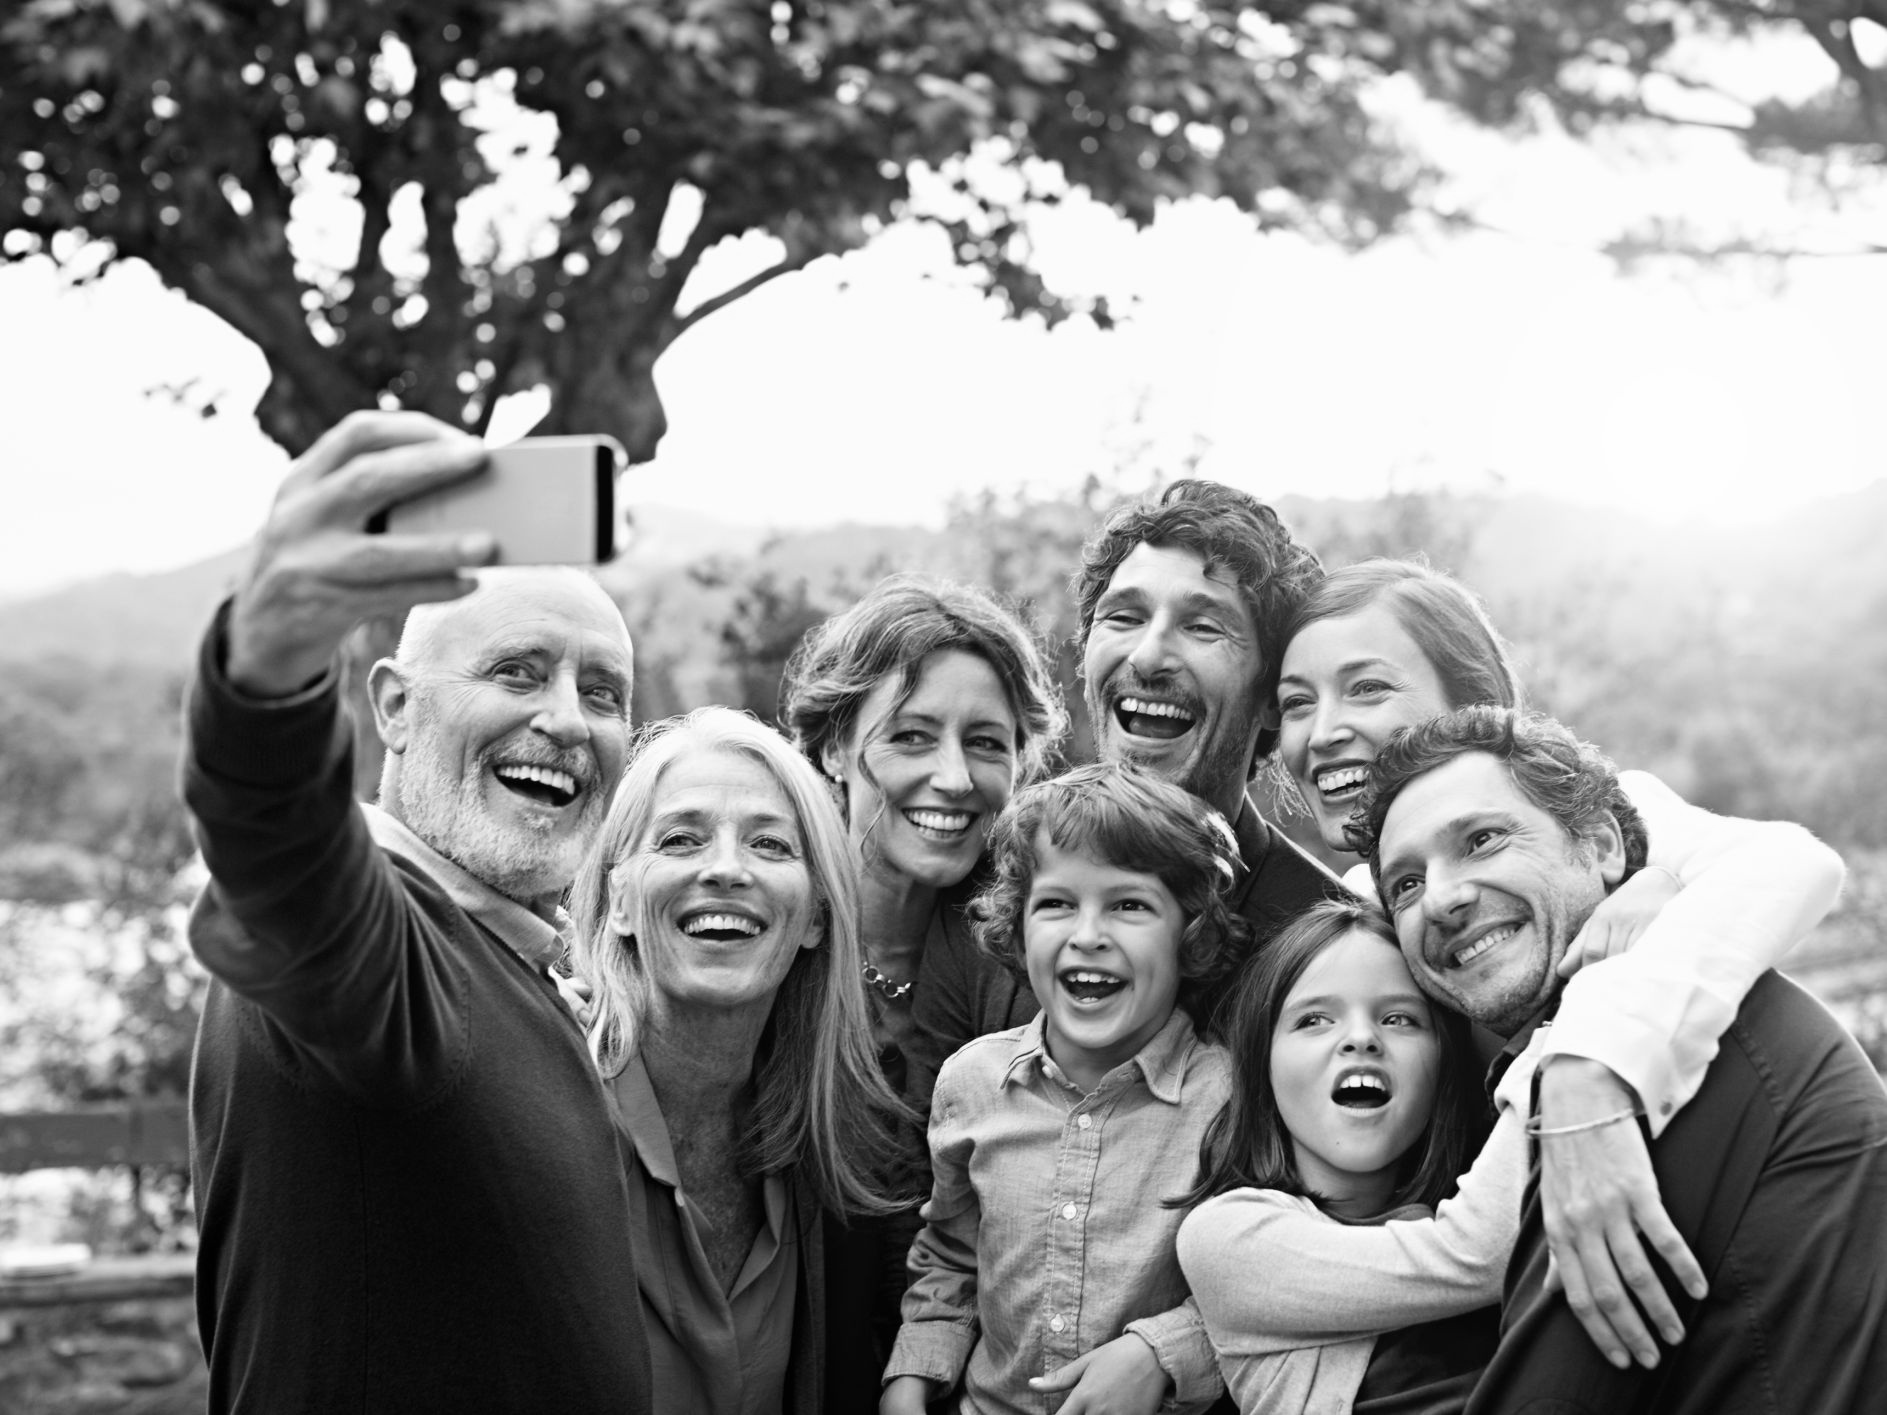

In [13]:
import cv2 # 導入OpenCV套件包
from google.colab.patches import cv2_imshow # 導入顯示OpenCV格式影像套件包
import numpy as np # 導入numpy套件包
import requests # 導入requests套件包

## 亦可選擇從網路獲取一張影像，轉成OpenCV格式並存檔，檔名photo.jpg
## 若選擇從網路上檔案來進行人臉辨識，則加入下面三行程式，否則加上註釋符號令其略過
file = requests.get("https://raw.githubusercontent.com/OmniXRI/Colab_DevCloud_OpenVINO_Samples/master/dataset/face_detection_01.jpg")
img_s = cv2.imdecode(np.fromstring(file.content, np.uint8), 1)
cv2.imwrite('photo.jpg',img_s)

img = cv2.imread('photo.jpg') # 讀入影像
gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) # 將影像轉為灰階格式
cv2_imshow(gray_img) # 顯示輸入灰階影像

## 4. 建立聯級開始人臉偵測

OpenCV提供了很多預訓練的人臉聯級(Cascade)檢測定義檔(xml)。一般在本地端有特定的存放路徑，在Colab虛擬機上則會放在 /usr/local/lib/python3.7/dist-packages/cv2/data/ 下，當找不到指定的xml檔案時會出現下列錯誤訊息。  
error: OpenCV(4.1.2) /io/opencv/modules/objdetect/src/cascadedetect.cpp:1689: error: (-215:Assertion failed) !empty() in function 'detectMultiScale'  
若仍不確定xml檔案所在路徑，則可使用下列指令來尋找。  
!find / -iname "haarcascade*"  
這裡僅先使用偵測正面人臉及眼睛的聯級定義來建立分類器，並偵測影像中共有多少人臉出現。  

In [14]:
# 宣告聯級檔案所在路徑及名稱
path_face = "/usr/local/lib/python3.7/dist-packages/cv2/data/haarcascade_frontalface_default.xml" # 正面人臉預訓練聯級檔
path_eyes = "/usr/local/lib/python3.7/dist-packages/cv2/data/haarcascade_eye.xml" # 眼睛預訓練聯級檔

face_cascade = cv2.CascadeClassifier(path_face) # 建立人臉分類器
eye_cascade  = cv2.CascadeClassifier(path_eyes) # 建立眼睛分類器

faces = face_cascade.detectMultiScale(gray_img, scaleFactor=1.1, minNeighbors=4) # 偵測影像中所有人臉
print(f"{len(faces)} faces detected in the image.") # 顯示偵測到的人臉數量

7 faces detected in the image.


## 5. 顯示人臉及眼睛位置

這裡會依據前項偵測的人臉位置繪制綠色外框。再裁切人臉部份影像（ROI）進行眼睛偵測，繪製紅框，可減少誤判率。  


1 eyes detected in the image.
1 eyes detected in the image.
2 eyes detected in the image.
2 eyes detected in the image.
5 eyes detected in the image.
5 eyes detected in the image.
4 eyes detected in the image.


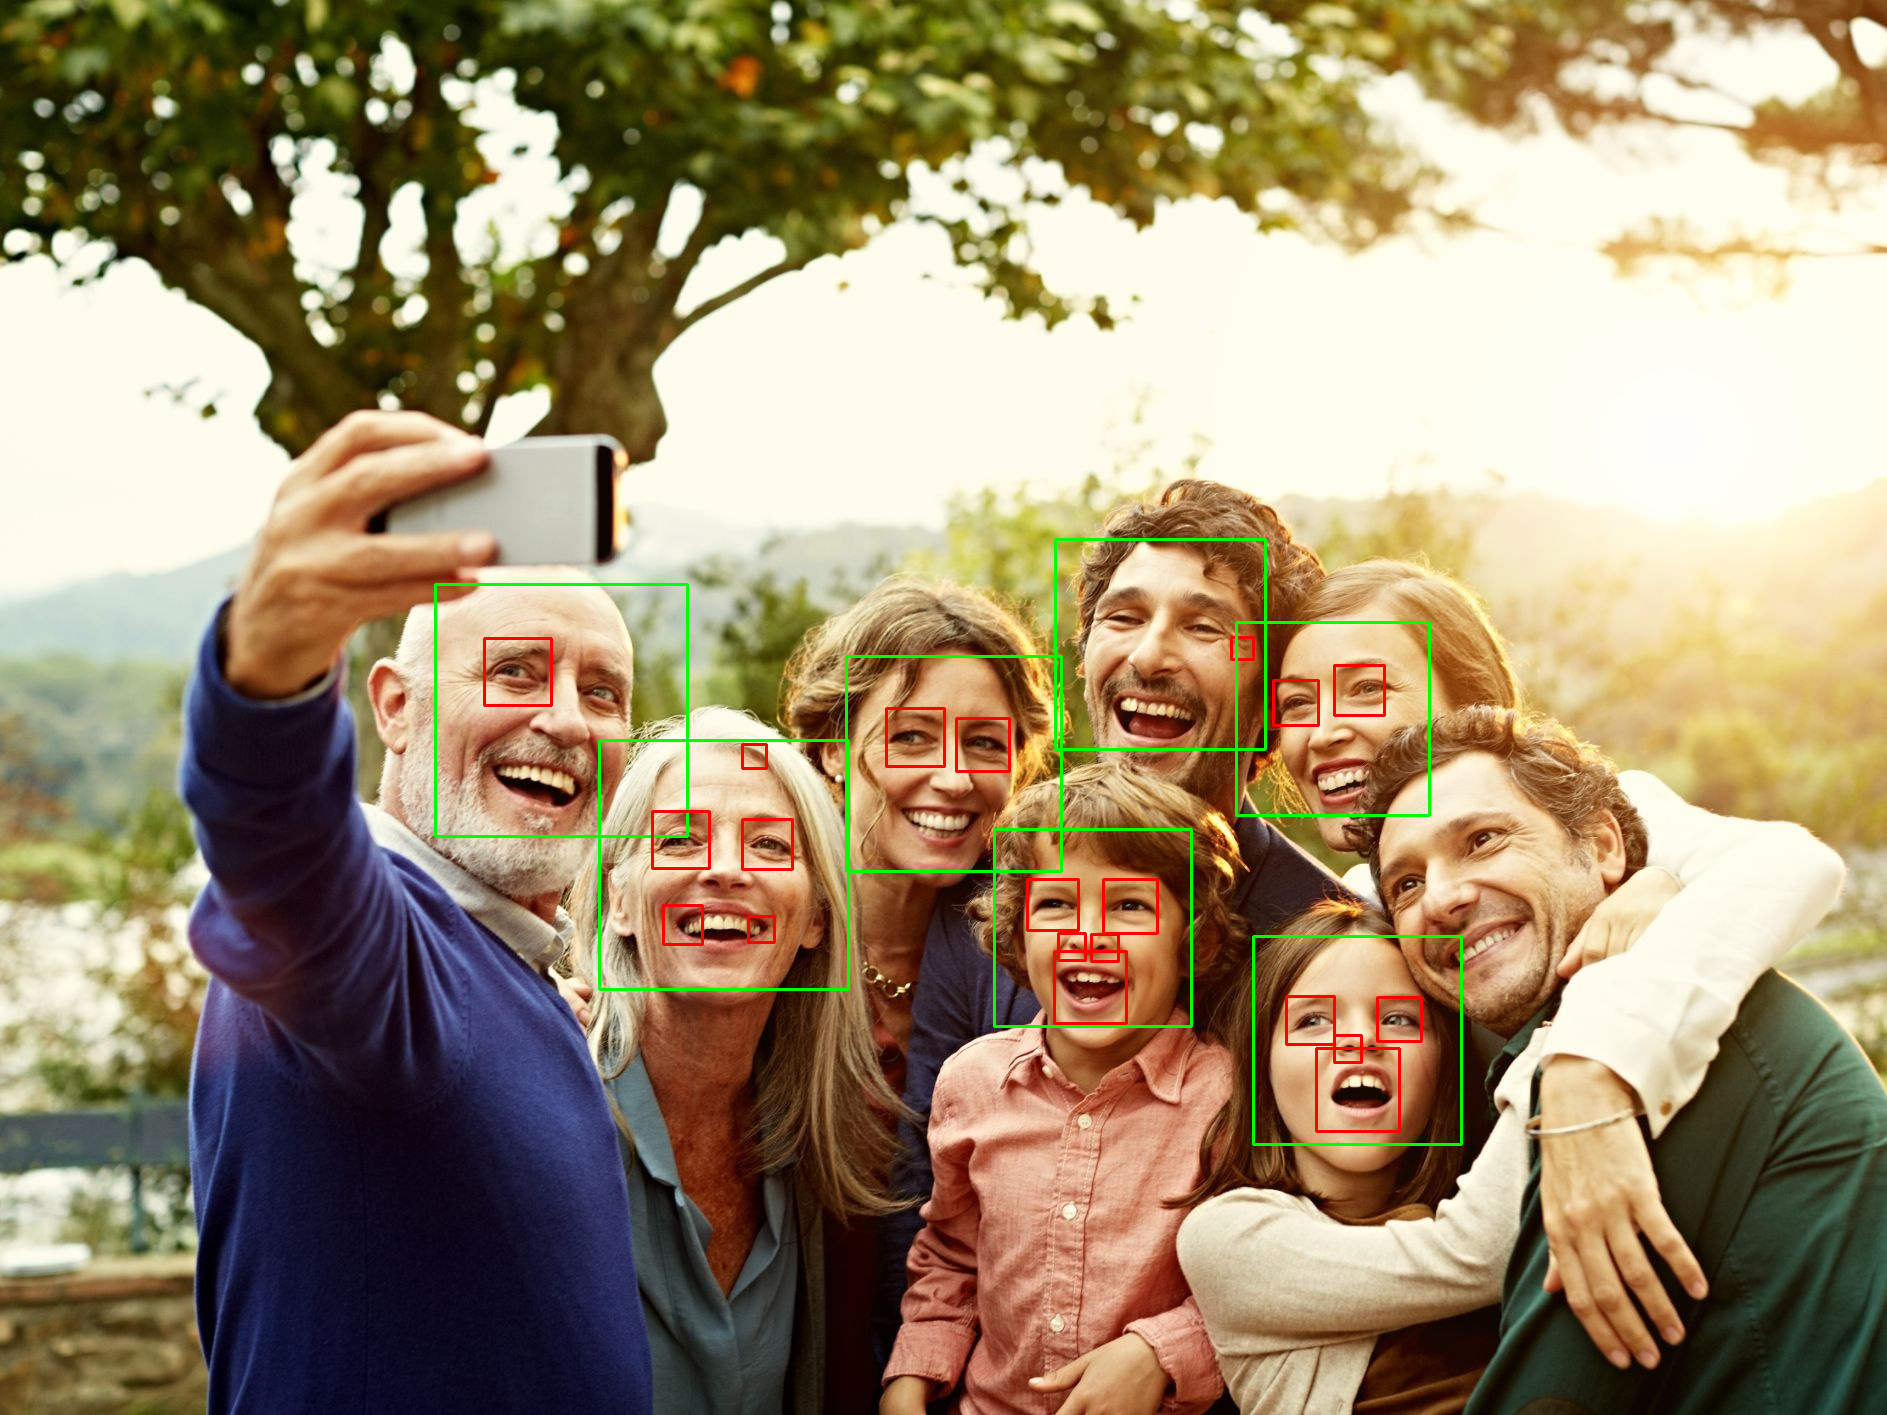

In [15]:
for x, y, w, h in faces:
    cv2.rectangle(img, (x,y), (x+w, y+h), color=(0,255,0), thickness=2) # 繪制人臉綠色外框
    
    roi = img[y:y+h, x:x+w] # 取得人臉部份影像
    roi_gray = gray_img[y:y+h, x:x+h] # 取得人臉部份灰階影像
    eyes = eye_cascade.detectMultiScale(roi_gray) # 進行眼睛位置偵測
    print(f"{len(eyes)} eyes detected in the image.") # 顯示偵測到的眼睛數量

    for ex, ey, ew, eh in eyes:
      cv2.rectangle(roi, (ex,ey), (ex+ew, ey+eh), color = (0,0,255), thickness=2) # 繪製眼睛紅色外框

cv2_imshow(img) # 顯示結果影像